In [1]:
import matplotlib.pyplot as plt
import numpy as np
from uncertainties import ufloat
from uncertainties.umath import log
from scipy.stats import norm

import tidef
from tidef.phase_curve import deformed_PC
from tidef.utils import transit_duration, convert_radius,inclination,impact_parameter

## simulate JWST PRISM phase curve observation of WASP-12 assuming its deformed

In [2]:
def_PC = deformed_PC(ld_law='power-2', deformed=True)
print(f"{def_PC.pars=}")

def_PC.pars={'t0': 0, 'P': 1, 'Rv': 0.1, 'aR': 3, 'inc': 90, 'e': 0, 'w': 90, 'ld_pars': [0.5, 0.5], 'qmass': 1, 'Fp': 0, 'Fn': 0, 'hf': 1.5, 'delta': 0, 'A_EV': 0, 'A_DB': 0}


In [3]:
P = 1.09141685
T14 = 3  #hrs
c, alp = ufloat(0.2755,0.01), ufloat(0.4261,0.01)
Qm = ufloat(0.00097,6.2e-5)
logQm = log(Qm)
logQm


-6.938214486466846+/-0.06391752577319587

In [14]:
sim_pars = def_PC.pars.copy()
sim_pars.update({"P":1,                      #period in days (1 for phase folded light curve)
                 "Rv":0.1239,                #planet-to-star radius_ratio
                 "aR":3.04,                  #scaled semi-major axis a/Rs
                 "inc":83.5,                 #inclination degrees
                 "ld_pars": [c.n, alp.n],    #power-2 limb darkening parameters
                 "Fp":3306,                  #dayside flux ppm
                 "Fn":500,                   #nightside ppm
                 "A_EV":60,                  #ellipsodial variation semi-amplitude in ppm
                 "delta":9,                  #hotspot offset in degrees
                 "hf":1.565,                 #planet love number
                 "qmass": Qm.n              #planet-to-star mass_ratio
                 })

print(sim_pars)

{'t0': 0, 'P': 1, 'Rv': 0.1239, 'aR': 3.04, 'inc': 83.5, 'e': 0, 'w': 90, 'ld_pars': [0.2755, 0.4261], 'qmass': 0.00097, 'Fp': 3306, 'Fn': 500, 'hf': 1.565, 'delta': 9, 'A_EV': 60, 'A_DB': 0}


In [15]:
Tobs    = P*24 + 2*T14 #hrs
print(Tobs)
cadence = 2 #mins

start_phase = 1-0.5*Tobs/(P*24)
end_phase   = 1+0.5*Tobs/(P*24)
npts        = int(Tobs*60/cadence)

phase   = np.linspace(start_phase, end_phase, npts)
print("len phase: ", len(phase))


32.194004400000004
len phase:  965


In [18]:
%timeit def_flux = def_PC.phase_curve(phase, sim_pars)

75.5 ms ± 633 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
def_flux = def_PC.phase_curve(phase, sim_pars)

#add noise level of 50ppm/2mins expected from jwst obsevation

def_flux += norm(0, 50e-6).rvs(len(phase), random_state=10)
err      = 50e-6 * np.ones_like(phase)

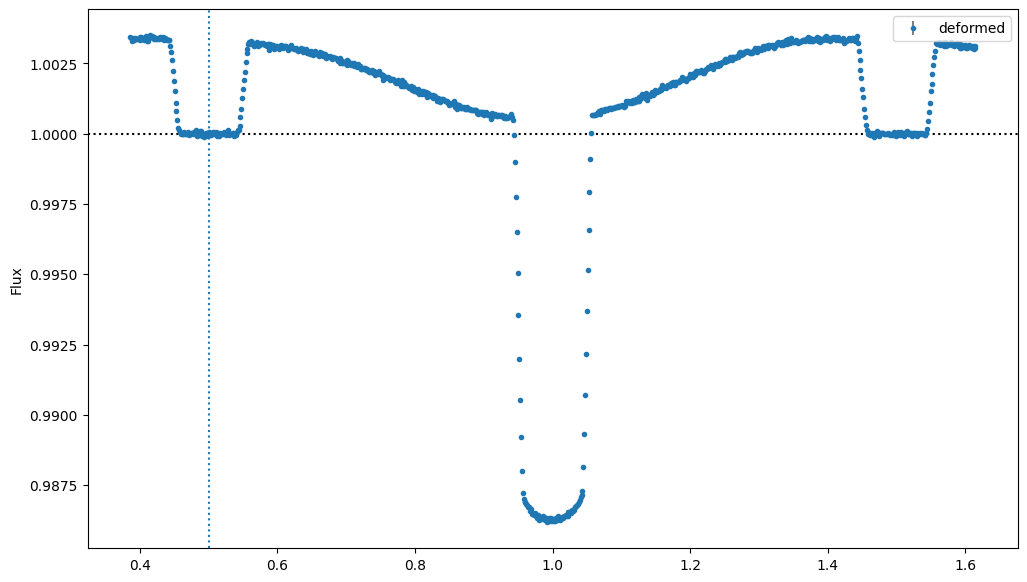

In [20]:
fig=plt.figure(figsize=(12,7))


plt.errorbar(phase, def_flux, err, fmt=".",label="deformed",ecolor="gray")
plt.axvline(0.5,ls=":")
plt.axhline(1,ls=":", color="k")
plt.ylabel("Flux")
plt.legend()


In [21]:
fit_pc = deformed_PC(ld_law='power-2', deformed=False)
fit_pars = fit_pc.pars.copy()

def fit_PC_model(pars,phase,deformed=False, return_components=False):

    fit_pars.update({"t0": pars[0],
                    "Rv":  pars[1], 
                    "aR":  pars[2],
                    "inc":   pars[3], 
                    # "inc": inclination(fit_pars), 
                    "ld_pars": [pars[4], pars[5]], 
                    "Fp":  pars[6], 
                    "Fn":  pars[7], 
                    "A_EV":pars[8], 
                    "delta":pars[9]})
    
    if deformed: fit_pars.update({"hf":pars[10], "qmass":pars[11]})
    
    if return_components:
        def_atm_signal, ellip_signal, DB_signal, pc_def_contrib = fit_pc.phase_curve(phase, fit_pars,return_components=return_components)
        return def_atm_signal, ellip_signal, DB_signal, pc_def_contrib
    
    fit_flux = fit_pc.phase_curve(phase, fit_pars)
    return fit_flux
    
#    ["t0","Rv,"aR","b","c","alp","Fp","Fn","A_EV","delta"]

In [22]:
from scipy.stats import norm, uniform,truncnorm, lognorm, loguniform, halfnorm
from better_uniform import buniform as buni

pc_priors = [buni(-0.01,0.01),           #T_0
            buni(0.09,0.13),             #Rp
            buni(2.5,3.5),               #aR
            buni(80,90),                   #inc
            truncnorm((0-c.n)/c.s,(1-c.n)/c.s, c.n,c.s),               #q1
            truncnorm((0-alp.n)/alp.s,(1-alp.n)/alp.s, alp.n,alp.s),               #q2
            buni(2500,4500),                #Fdayppm
            buni(300,800),                #F_n
            buni(0,600),                 #A_ellip
            buni(-25,25),                 #delta
            ]
            # buni(0,2.5),                #hf
            # norm(logQm.n,logQm.s)       #log_qmass
            # ]           
 

pc_labels =["$T_0$","$R_{p}/R_{\\ast}$","$a/R_{\\ast}$","inc", "$c$","$\\alpha$",
         "$F_p$", "$F_{n}$", "$A_{ellps}$",  "$\\delta$"]

ndim = len(pc_priors)
ndim, len(pc_labels)


(10, 10)

In [23]:
# pars = [sim_pars[p] for p in ["t0","Rv","aR","inc","ld_pars","Fp","Fn","A_EV","delta"]]
pars = 0, 0.1239, 3.04, 83.5, 0.2755, 0.4261, 3306, 500, 60, 9

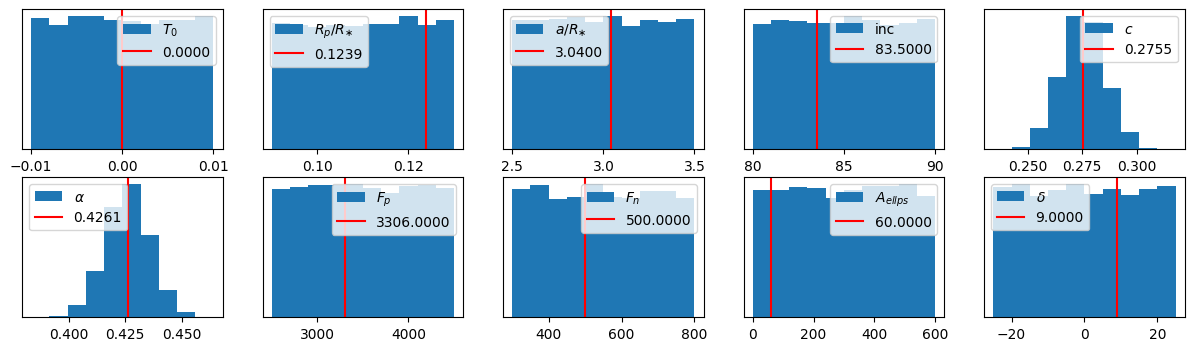

In [24]:
fig_pcprior, ax = plt.subplots(2,int(np.ceil(len(pc_priors)/2)), figsize=(15, 4))
ax = ax.reshape(-1)

for i in range(len(pc_priors)):
    ax[i].hist(pc_priors[i].rvs(10000), label= f"{pc_labels[i]}", density=True);
    ax[i].set_yticks([])
    ax[i].axvline(pars[i], color="red", label=f"{pars[i]:.4f}")
    ax[i].legend()

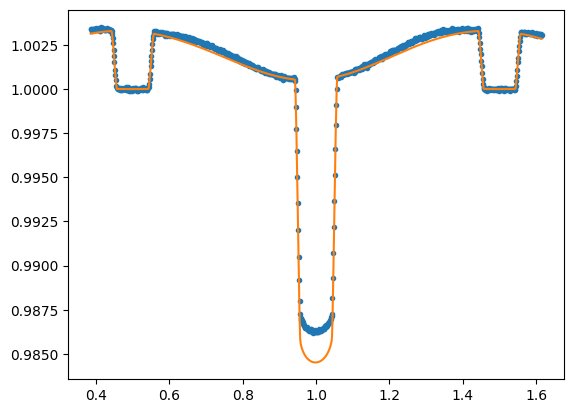

In [25]:
plt.errorbar(phase, def_flux, err, fmt=".",label="deformed",ecolor="gray")


fit_flux = fit_PC_model(pars,phase)
plt.plot(phase, fit_flux,zorder=3)

## dynesty sampling

In [28]:
def prior_transform(u, pc_priors):
    x = np.array(u)  # copy u
    for i, pr in enumerate(pc_priors):
        x[i] = pr.ppf(u[i])
    return x

def log_likelihood(params,ph,y,yerr):
    pc_mod = fit_PC_model(params,ph,deformed=False)
    sig = yerr #np.hypot(yerr,np.exp(params[-1]))
    return norm(y, sig).logpdf(pc_mod).sum()
    

In [29]:
log_likelihood(pars,phase,def_flux,err)

-38918.379957470315

In [30]:
from dynesty import utils as dyfunc
from Planet_tools.utils import dynesty_results
import pickle, dynesty
import dynesty.plotting as dyplot
import multiprocessing as mp
mp.set_start_method('fork')
from multiprocessing import Pool


RuntimeError: context has already been set

In [ ]:
sampler = dynesty.NestedSampler(log_likelihood, prior_transform, ndim,
                                logl_args=(phase,def_flux,err), ptform_args=(pc_priors,),
                                nlive=200,sample="rwalk",pool= Pool(10),  queue_size=8)
sampler.run_nested(dlogz=0.01)
res=sampler.results
res.summary()

In [34]:
res.summary()

Summary
nlive: 200
niter: 532
ncall: 2271
eff(%): 21.530
logz: -144762.062 +/-  0.294


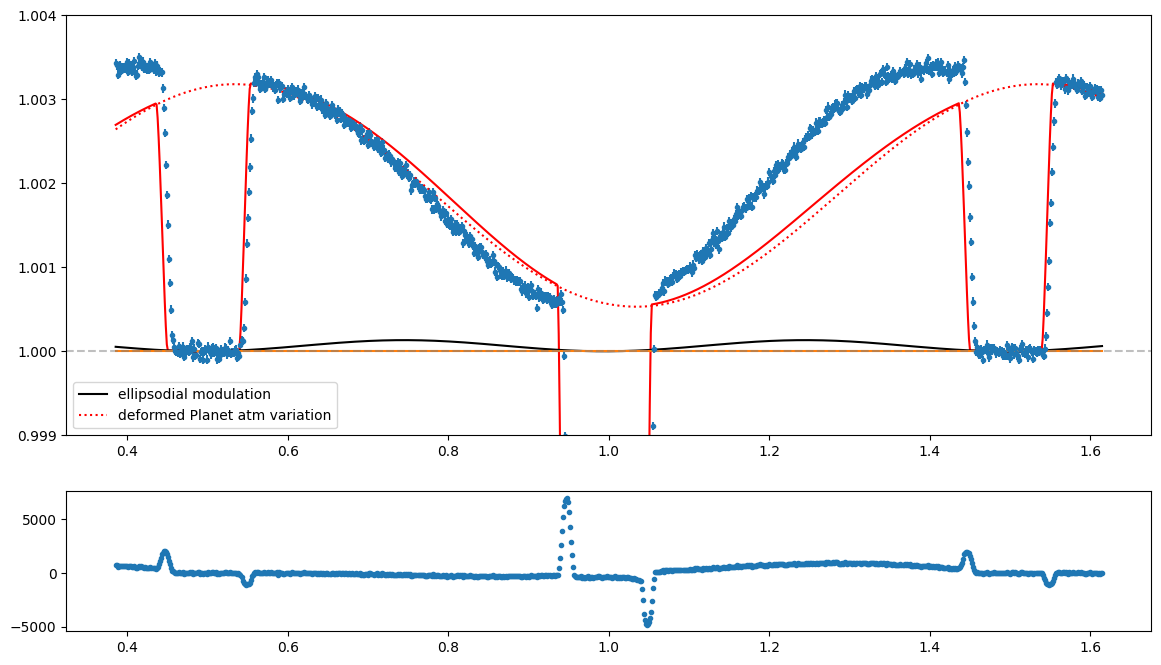

In [42]:
fit_params = dynesty_results(res)
pc_fit     = fit_PC_model(fit_params,phase)
atm_signal,ellps,dopp, def_contrib = fit_PC_model(fit_params,phase,return_components=True)

fig,ax = plt.subplots(2,1,figsize=(14,8), gridspec_kw={"height_ratios":(3,1)})
ax[0].errorbar(phase, def_flux, err, fmt=".")
ax[0].plot(phase,pc_fit,"r")
ax[0].plot(phase, 1+ellps,"k",label="ellipsodial modulation")
ax[0].plot(phase, 1+atm_signal,"r:", label="deformed Planet atm variation")
ax[0].plot(phase, 1+def_contrib)
ax[0].axhline(1,ls="--",color="gray",alpha=0.5)
ax[0].legend()
ax[0].set_ylim([0.999,1.004])
ax[1].plot(phase, 1e6*(def_flux - pc_fit),".")


